#FAST FOURIER TRANSFORM

[VSB Power Line Fault Detection](https://www.kaggle.com/competitions/vsb-power-line-fault-detection/data)

**Mô tả về dữ liệu:**

- Problem: xử lý các sự cố trong các đường dây truyền tải điện, dẫn đến hiện tượng phóng điện một phần. Nếu không được giải quyết, phóng điện một phần có thể gây hại nghiêm trọng cho thiết bị, có thể dẫn đến hỏng hoàn toàn. Thách thức là phát hiện các phóng điện một phần sớm, cho phép sửa chữa kịp thời và ngăn chặn hư hại nghiêm trọng.

- Signal data: mỗi tín hiệu được ghi lại bao gồm 800,000 lần đo điện áp được thực hiện từ một đường dây điện trong thời gian 20 mili giây. Vì lưới điện hoạt động với tần số 50 Hz, thời gian này bao gồm một chu kỳ hoàn chỉnh của lưới điện. Dữ liệu cũng phản ánh hệ thống điện 3 pha, có nghĩa là cả ba pha đều được giám sát đồng thời.

**Mô tả về features:**

- metadata_[train/test].csv:

  - `id_measurement`: mã ID cho bộ ba tín hiệu được ghi cùng lúc.
  - `signal_id`: định danh duy nhất cho mỗi tín hiệu, phân biệt giữa bộ dữ liệu train và test. Các ID là tuần tự nhưng riêng biệt cho train và test (bắt đầu từ '0' cho train và '8712' cho test).
  - `phase`: mã ID pha trong bộ ba tín hiệu. Các pha có thể bị ảnh hưởng hoặc không bởi sự cố trên đường dây.
  - `target`: Chỉ ra điều kiện của pha '0' nếu không có lỗi và '1' nếu phát hiện lỗi trong đường dây.
- [train/test].parquet: lưu trữ dữ liệu tín hiệu thực tế. Mỗi cột trong tệp Parquet đại diện cho một tín hiệu chứa 800,000 lần đo, được lưu trữ dưới dạng kiểu dữ liệu int8. Tệp Parquet được cấu trúc để tải dữ liệu lớn một cách hiệu quả, đặc biệt hữu ích cho việc truy cập một phần dữ liệu mà không cần tải toàn bộ tệp vào bộ nhớ.

## Mount drive and Import libraries

Vì data khá lớn nên nhóm em đã lưu ở drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## 1. Loading data


**1.1 Tải dữ liệu từ file train.parquet vào biến signals dưới dạng DataFrame của Pandas.**

- Hàm `pq.read_table`: đọc dữ liệu từ file Parquet (Parquet là một định dạng lưu trữ cột hiệu quả cho Hadoop, thường được sử dụng trong xử lý dữ liệu lớn do khả năng nén cao và đọc/ghi nhanh).

- Tham số `columns=[str(i) for i in range(999)]`: chỉ định danh sách các cột để đọc vào, từ cột '0' đến cột '998'.

- `.to_pandas()`: chuyển đổi kết quả đọc được thành DataFrame Pandas.

In [ ]:
signals = pq.read_table('/content/drive/MyDrive/Colab Notebooks/train.parquet', columns=[str(i) for i in range(999)]).to_pandas()
signals

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,18,1,-19,-16,-5,19,-15,15,-1,-16,...,4,-18,10,9,18,-20,1,18,-19,-6
1,18,0,-19,-17,-6,19,-17,16,0,-15,...,1,-20,8,8,20,-19,2,18,-18,-6
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,...,1,-20,6,6,17,-22,0,18,-18,-6
3,18,1,-19,-16,-5,20,-16,16,0,-15,...,3,-21,5,6,18,-19,1,18,-18,-6
4,18,0,-19,-16,-5,20,-17,16,-2,-14,...,3,-20,5,6,19,-21,1,19,-18,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,19,2,-18,-15,-4,21,-16,16,-1,-17,...,-1,-21,6,6,16,-19,1,20,-17,-5
799996,19,1,-19,-15,-4,20,-17,15,-3,-18,...,1,-21,6,6,15,-21,1,20,-18,-5
799997,17,0,-19,-15,-4,21,-16,14,-2,-18,...,4,-19,7,8,16,-19,1,19,-17,-5
799998,19,1,-18,-14,-3,22,-16,17,-1,-17,...,0,-19,8,8,16,-19,1,20,-18,-6


**1.2. Reshape dữ liệu tín hiệu để phù hợp với việc phân tích. Mỗi tín hiệu được ghi lại trong một cột của DataFrame, và mỗi tín hiệu chứa 800,000 điểm dữ liệu.**

- `np.array(signals)`: Chuyển DataFrame signals thành một mảng NumPy.

- `.T`: Chuyển vị (transpose) mảng để cột trở thành hàng và ngược lại. Thay đổi cách dữ liệu được tổ chức từ "cột theo tín hiệu" sang "hàng theo tín hiệu".

- `.reshape((999//3, 3, 800000))`: Dùng để tái cấu trúc mảng thành ba chiều, với kích thước mới là `(333, 3, 800000)`. Mỗi tín hiệu điện áp có 800,000 điểm dữ liệu, và mỗi bộ ba tín hiệu (ứng với ba pha của hệ thống điện) được tổ chức cùng nhau.

In [ ]:
signals = np.array(signals).T.reshape((999//3, 3, 800000))
signals

array([[[ 18,  18,  17, ...,  17,  19,  17],
        [  1,   0,  -1, ...,   0,   1,   0],
        [-19, -19, -20, ..., -19, -18, -19]],

       [[-16, -17, -17, ..., -15, -14, -14],
        [ -5,  -6,  -6, ...,  -4,  -3,  -4],
        [ 19,  19,  19, ...,  21,  22,  21]],

       [[-15, -17, -17, ..., -16, -16, -17],
        [ 15,  16,  15, ...,  14,  17,  14],
        [ -1,   0,  -3, ...,  -2,  -1,  -4]],

       ...,

       [[-18, -20, -20, ..., -19, -19, -18],
        [ 10,   8,   6, ...,   7,   8,   9],
        [  9,   8,   6, ...,   8,   8,   9]],

       [[ 18,  20,  17, ...,  16,  16,  14],
        [-20, -19, -22, ..., -19, -19, -21],
        [  1,   2,   0, ...,   1,   1,   0]],

       [[ 18,  18,  18, ...,  19,  20,  19],
        [-19, -18, -18, ..., -17, -18, -17],
        [ -6,  -6,  -6, ...,  -5,  -6,  -5]]], dtype=int8)

**1.3. Đồ thị của của các tín hiệu:**

Vẽ đồ thị cho ba pha tín hiệu từ bộ ba tín hiệu đầu tiên trong mảng đã reshape.

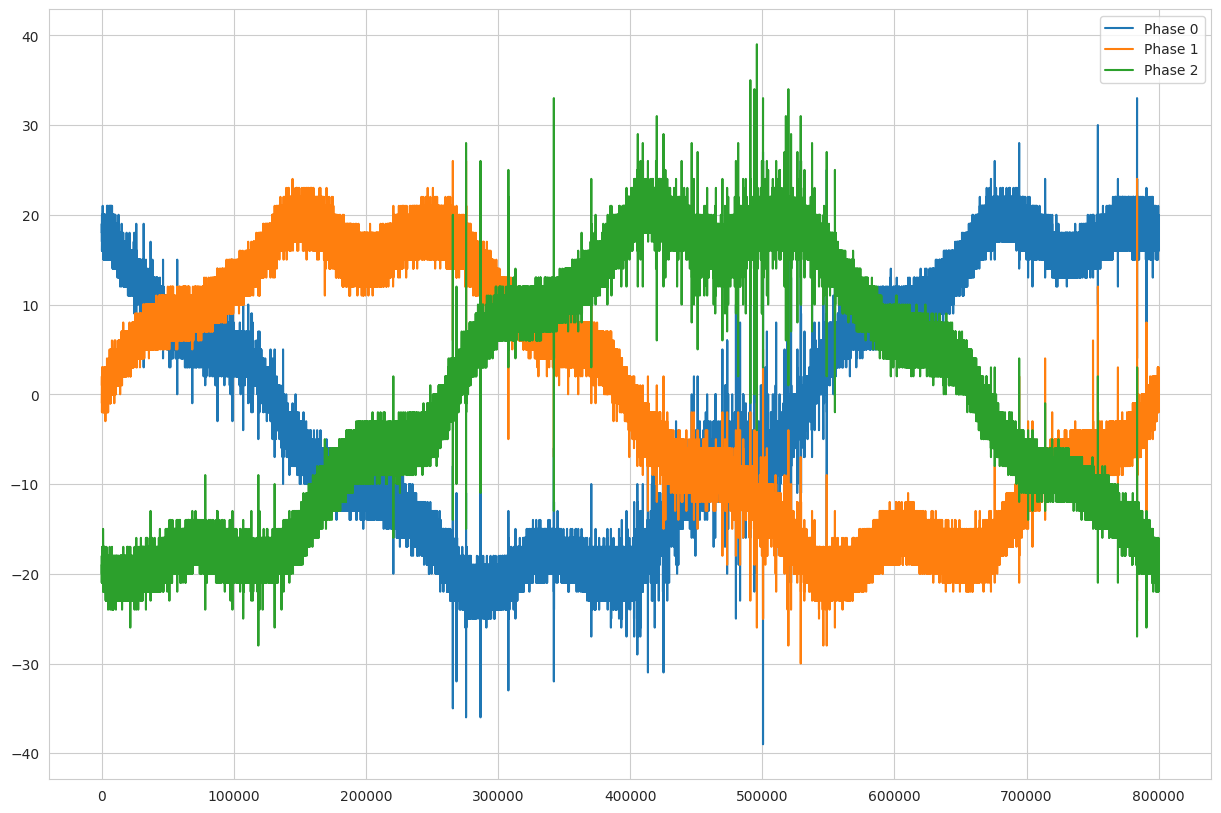

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Phase 0')
plt.plot(signals[0, 1, :], label='Phase 1')
plt.plot(signals[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

## 2. Target

**2.1. Đọc dữ liệu từ file metadata_train.csv và hiển thị một vài dòng đầu tiên.**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/metadata_train.csv')
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


**2.2 Lấy cột 'target' từ DataFrame.**

Ở đây, nhóm chỉ lấy mỗi giá trị thứ ba (bắt đầu từ chỉ số 0). Mục đích làm giảm số lượng dữ liệu cần xử lý và phân tích.

In [ ]:
target = train_df['target'][::3]
target

0       0
3       1
6       0
9       0
12      0
       ..
8697    0
8700    0
8703    0
8706    0
8709    0
Name: target, Length: 2904, dtype: int64

**2.3. Đếm số lượng Target và vẽ biểu đồ.**

- `value_counts()`: đếm số lượng mỗi giá trị duy nhất trong `target`, tức là đếm số lượng `target`là 0 và 1.

- Vẽ biểu đồ cột, trục x là chỉ số (0 và 1, tương ứng với không có lỗi và có lỗi); trục tung là số lượng của mỗi loại.







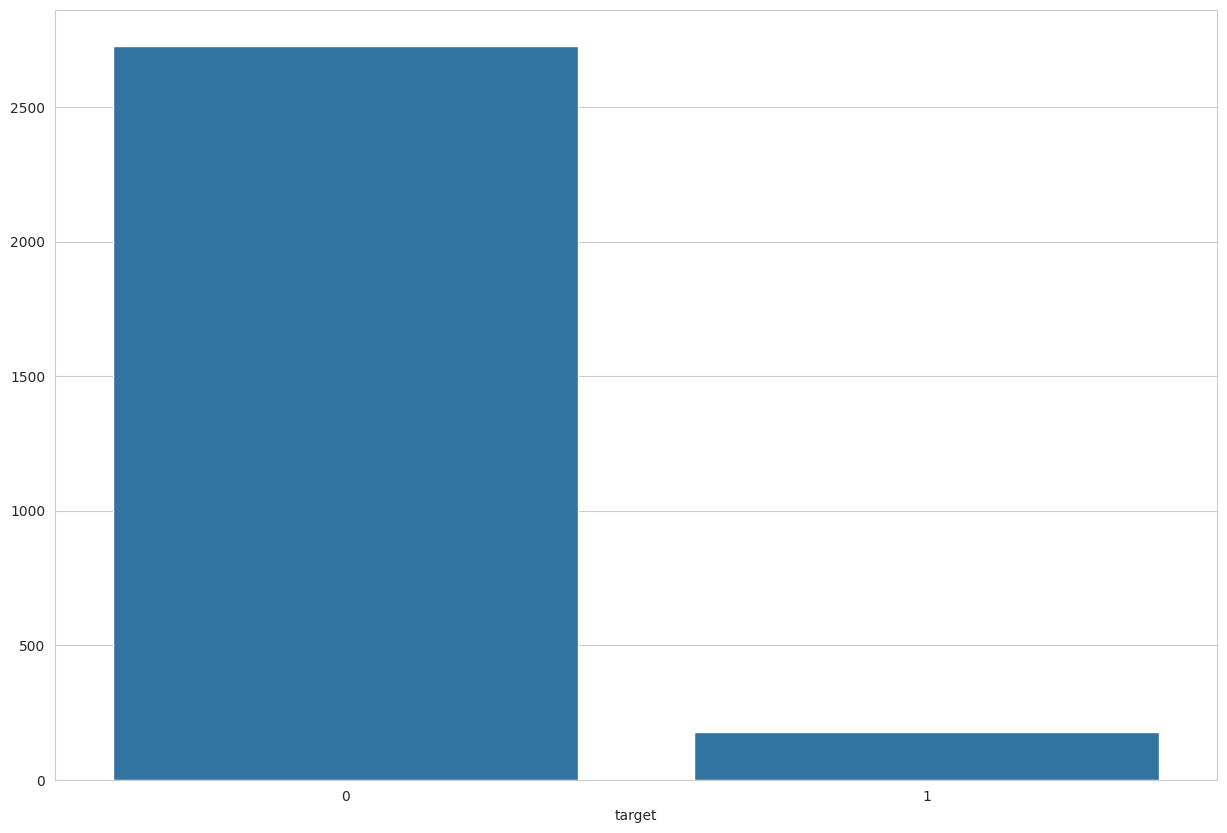

In [ ]:
target_count = target.value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=target_count.index, y=target_count.values)
plt.show()

##3. Smoothing by mean

**3.1. Hàm sample: giảm độ phân giải theo thời gian của tín hiệu bằng cách thay thế `kernel_size` điểm liên tiếp bằng trung bình của chúng, làm mịn các biến động ngắn hạn và làm nổi bật các xu hướng lâu dài hơn trong data.**

- `def sample(signal, kernel_size)`: định nghĩa hàm với hai tham số, `signal` là mảng NumPy ba chiều chứa tín hiệu cần xử lý và `kernel_size` là số lượng điểm dữ liệu liên tiếp để tính trung bình cho mỗi điểm dữ liệu mới.

- `sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))`: khởi tạo một mảng NumPy mới có cùng số hàng và cột như `signal` nhưng có ít điểm dữ liệu hơn theo chiều thứ ba. Số lượng điểm dữ liệu mới này được tính bằng cách lấy tổng số điểm dữ liệu ban đầu (`signal.shape[2]`) chia cho `kernel_size`.

- `for i in range(signal.shape[2]//kernel_size)`: vòng lặp này chạy qua các phân đoạn của mảng `signal` dựa trên `kernel_size`. Với mỗi lần lặp, nó xác định một khối dữ liệu để tính trung bình.

- `begin = kernel_size * i` và `end = min(kernel_size * (i + 1), signal.shape[2])`: đây là các chỉ số bắt đầu và kết thúc của khối data hiện tại mà hàm sẽ tính trung bìnhh. Nếu `kernel_size` là 100, khối đầu tiên sẽ bao gồm các điểm từ chỉ số 0 đến 99, khối tiếp theo từ 100 đến 199, và cứ tiếp tục như vậy cho đến khi kết thúc mảng.

- `sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)`:  tính trung bình của `signal` trên khối được xác định (từ `begin` đến `end`) theo chiều thứ ba (`axis=2`) và lưu trữ kết quả vào mảng `sampled` tại vị trí tương ứng.

- `return sampled`: trả về mảng `sampled` chứa tín hiệu đã được làm mịn.

In [ ]:
def sample(signal, kernel_size):
    sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))
    for i in range(signal.shape[2]//kernel_size):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)
    return sampled

**3.2. Áp dụng Smoothing by mean cho `signals` với `kernal_size` là 100.**

Ở bước này:

1. Hàm `sample` sẽ được gọi với hai mảng `signals` và `100` làm kích thước kernel cho đường trung bình động.
2. Hàm sẽ tạo một mảng mới `sampled`, mảng này sẽ có cùng số hàng và cột như `signals`, nhưng độ dài của chiều thứ ba sẽ bị giảm đi 100 vì đường trung bình động được tính trên cứ 100 điểm của tín hiệu ban đầu.
3. Với mỗi bộ 100 điểm dọc theo chiều thứ ba của `signals`, hàm sẽ tính giá trị trung bình và lưu trữ ở vị trí tương ứng trong mảng `sampled`.
4. Cuối cùng, hàm sẽ trả về mảng `sampled`, hiện chứa tín hiệu đã được làm mịn.

In [ ]:
sampled = sample(signals, 100)

**3.3. Đồ thị của của các tín hiệu sau khi được làm mịn:**


Sử dụng thư viện Matplotlib để vẽ biểu đồ các pha của tín hiệu đã được làm mịn.

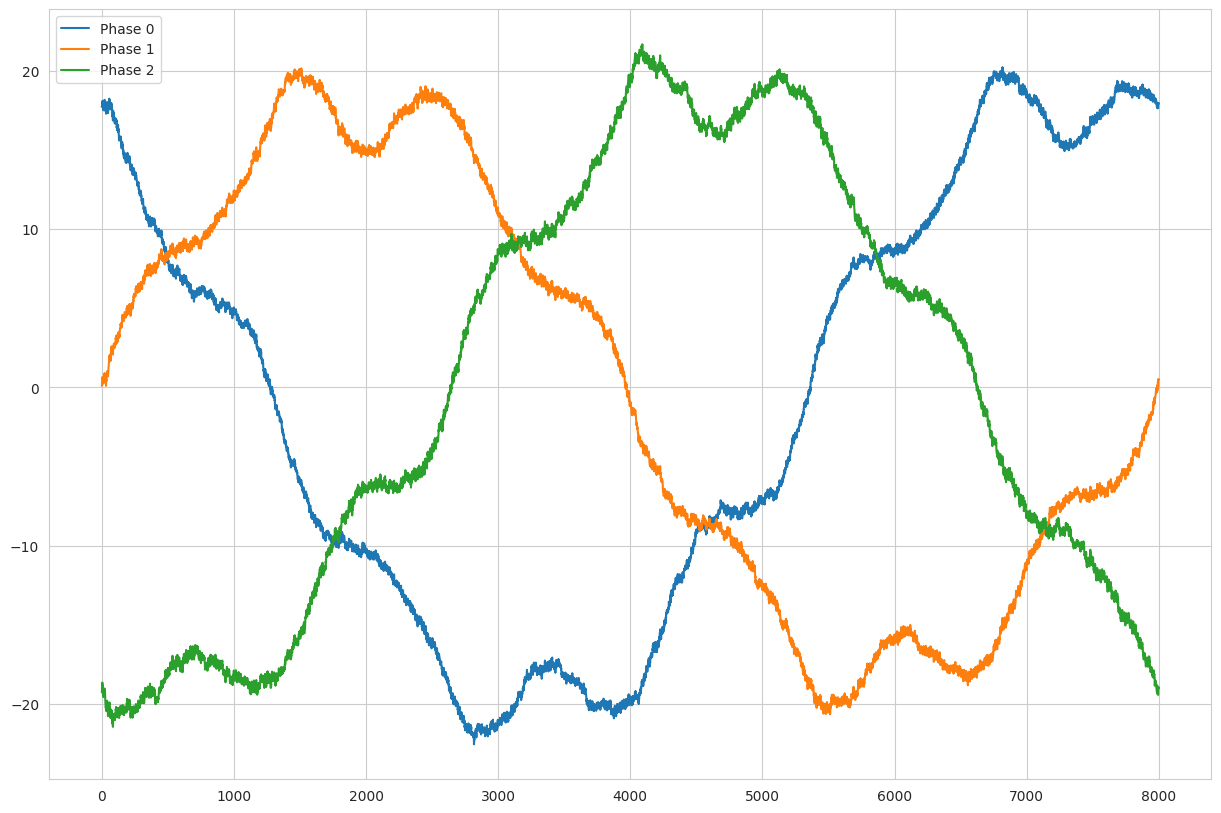

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sampled[0, 0, :], label='Phase 0')
plt.plot(sampled[0, 1, :], label='Phase 1')
plt.plot(sampled[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

## 4. Song song hóa bước Smoothing by mean


**4.1. Hàm `sample_parallel` thực hiện việc làm mịn một mảng tín hiệu đa chiều thông qua phương pháp Moving Averages.**

- `@jit(nopython=True, parallel=True)`: một decorator từ thư viện Numba, biên dịch hàm sử dụng LLVM compiler framework. `nopython` đảm bảo rằng code chạy mà không cần GIL (Global Interpreter Lock) của Python, và `parallel=True` cho phép tự động song song hóa việc thực thi hàm.

- `def sample_parallel(signal, kernel_size)`: định nghĩa hàm với hai tham số là `signal`, một mảng NumPy chứa dữ liệu tín hiệu và `kernel_size`, một số nguyên biểu diễn kích thước của window mà trên đó tính toán giá trị trung bình.

- `new_length = signal.shape[2] // kernel_size`: tính toán xem có bao nhiêu windows có kích thước `kernel_size` vừa với chiều thứ ba của `signal`.

- `sampled = np.zeros((signal.shape[0], signal.shape[1], new_length), dtype=np.float32)`: khởi tạo một mảng mới NumPy kiểu `float32` để lưu trữ tín hiệu đã được làm mịn, với chiều thứ ba giảm xuống tương ứng với `new_length`.

- `for i in prange(new_length)`: lặp qua chiều dài mới của chiều thứ ba sử dụng `prange`, cho phép thực thi song song vòng lặp.

- Bên trong các vòng lặp lồng nhau qua `j` và `k`, lặp qua hai chiều đầu tiên của `signal` và ở đây:
   - Một biến tạm thời `segment_sum` được sử dụng để tính tổng các giá trị tín hiệu trong window hiện tại được định nghĩa bởi `begin` và `end`.
   - Trung bình của window hiện tại được tính toán thủ công bằng cách chia `segment_sum` cho số lượng phần tử trong window (được cho bởi `(end - begin)`).
   - Giá trị trung bình tính toán được gán vào vị trí tương ứng trong mảng `sampled`.

- `return sampled`: trả về mảng tín hiệu đã được làm mịn `sampled`.


In [ ]:
from numba import jit, prange
import time

@jit(nopython=True, parallel=True)
def sample_parallel(signal, kernel_size):
    new_length = signal.shape[2] // kernel_size
    sampled = np.zeros((signal.shape[0], signal.shape[1], new_length), dtype=np.float32)  # Ensure dtype is float for mean calculation
    for i in prange(new_length):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        for j in range(signal.shape[0]):
            for k in range(signal.shape[1]):
                # Manually compute the mean to avoid issues with np.mean and datatypes in Numba
                segment_sum = 0.0
                for l in range(begin, end):
                    segment_sum += signal[j, k, l]
                segment_mean = segment_sum / (end - begin)
                sampled[j, k, i] = segment_mean
    return sampled

**4.2. So sánh thời gian thực thi của hai hàm xử lý tín hiệu.**


In [ ]:
# Đo thời gian cho hàm sample
start_time_sample = time.time()
sampled = sample(signals, 100)
end_time_sample = time.time()
total_time_sample = end_time_sample - start_time_sample

print(f"Thời gian thực thi của hàm sample: {total_time_sample:.2f} giây")

#Đo thời gian cho hàm sample_parallel
# Note: cần "Warm up" cho hàm sample_parallel vì là lần đầu tiên chạy để tránh tính thời gian biên dịch numba vào thời gian thực thi.
sample_parallel(signals, 100)  # "Warm up" for Numba compilation

start_time_parallel = time.time()
sampled_parallel = sample_parallel(signals, 100)
end_time_parallel = time.time()
total_time_parallel = end_time_parallel - start_time_parallel

print(f"Thời gian thực thi của hàm sample_parallel: {total_time_parallel:.2f} giây")

Thời gian thực thi của hàm sample: 2.58 giây
Thời gian thực thi của hàm sample_parallel: 0.90 giây
